**Step 1: Import Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**Step 2: Load Dataset and Check Info**

In [2]:
df = pd.read_csv("/kaggle/input/rainfall-prediction-dataset-cleaned-weatheraus/weatherAUS_rainfall_prediction_dataset_cleaned.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2010-04-30,Adelaide,10.8,21.2,0.0,1.8,6.60,ENE,22.0,ENE,...,66.0,48.0,1028.4,1024.7,4.45,4.51,15.7,21.0,No,No
1,2014-07-22,Adelaide,3.7,19.0,0.0,1.4,7.61,N,24.0,N,...,75.0,32.0,1024.2,1021.1,4.45,4.51,9.6,18.5,No,No
2,2014-07-23,Adelaide,9.6,15.8,0.0,2.6,7.61,NE,52.0,NNE,...,35.0,51.0,1017.9,1011.5,4.45,4.51,14.7,15.4,No,Yes
3,2014-07-24,Adelaide,10.1,15.5,16.6,0.8,7.61,NNE,50.0,NW,...,96.0,80.0,1007.4,1008.0,4.45,4.51,11.2,14.0,Yes,Yes
4,2014-07-25,Adelaide,11.2,16.2,1.8,0.6,7.61,NW,30.0,WNW,...,89.0,70.0,1018.4,1019.2,4.45,4.51,13.0,15.3,Yes,Yes


In [3]:
print(df.shape)
print(df.columns.tolist())
df.info()

(145460, 23)
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        145460 non-null  float64
 3   MaxTemp        145460 non-null  float64
 4   Rainfall       145460 non-null  float64
 5   Evaporation    145460 non-null  float64
 6   Sunshine       145460 non-null  float64
 7   WindGustDir    145460 non-null  object 
 8   WindGustSpeed  145460 non-null  float64
 9   WindDir9am     145460 non-null  object 
 10  WindDir3pm     145460 

In [4]:
df = df.dropna(subset=["RainTomorrow"]).copy()

df["RainTomorrow"] = df["RainTomorrow"].map({"Yes": 1, "No": 0}).astype(int)

if df["RainToday"].dtype != "O":
    df["RainToday"] = df["RainToday"].map({1: "Yes", 0: "No"}).astype("object")

**Step 3: Exploratory Data Analysis (EDA)**

**Target Class Distribution**

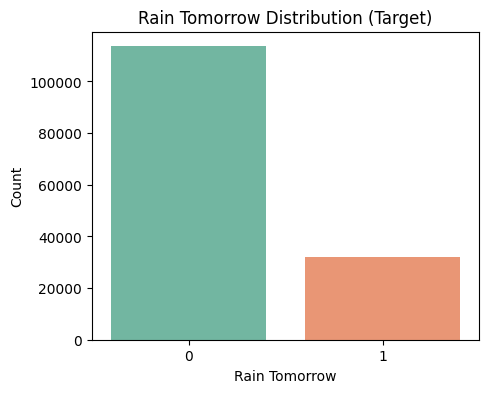

In [5]:
plt.figure(figsize=(5,4))
sns.countplot(x="RainTomorrow", data=df, palette="Set2")
plt.title("Rain Tomorrow Distribution (Target)")
plt.xlabel("Rain Tomorrow")
plt.ylabel("Count")
plt.show()

**Rainfall Distribution**

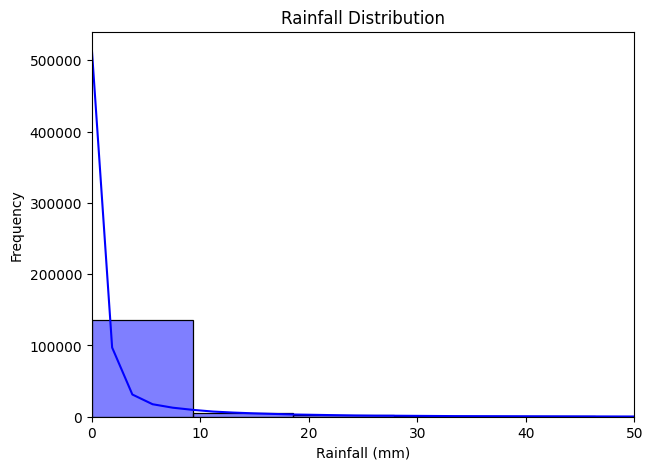

In [6]:
plt.figure(figsize=(7,5))
sns.histplot(df["Rainfall"], bins=40, kde=True, color="blue")
plt.title("Rainfall Distribution")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.xlim(0,50) 
plt.show()

**Min-Max Temp vs RainTomorrow**

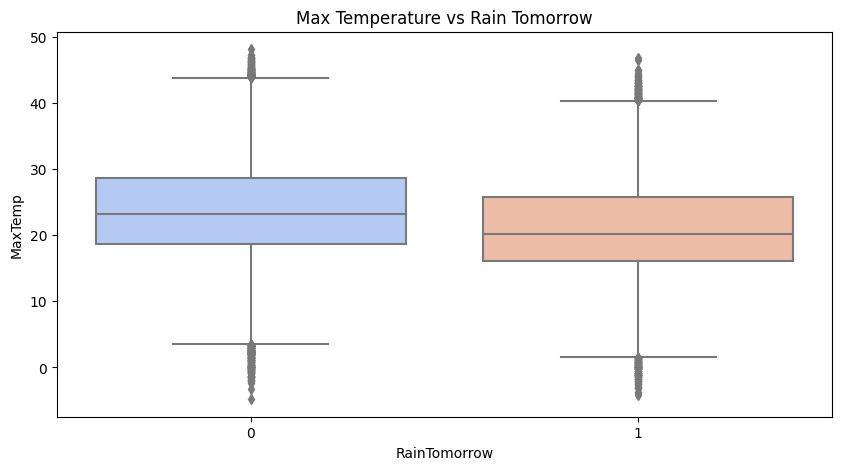

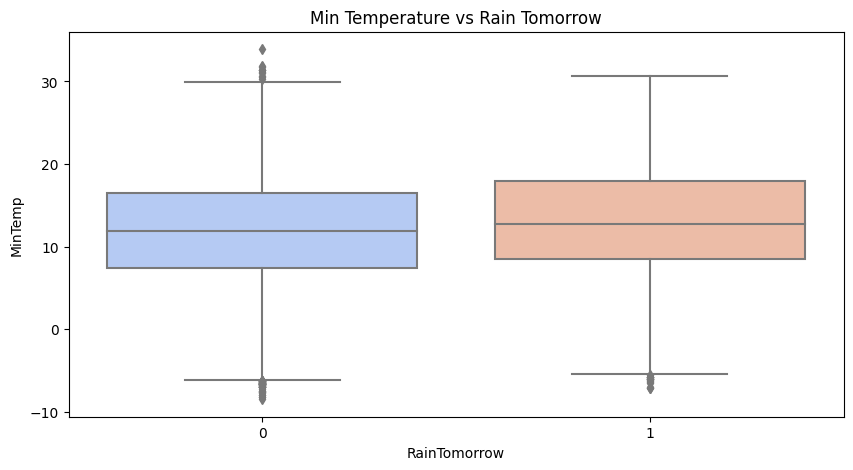

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x="RainTomorrow", y="MaxTemp", data=df, palette="coolwarm")
plt.title("Max Temperature vs Rain Tomorrow")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="RainTomorrow", y="MinTemp", data=df, palette="coolwarm")
plt.title("Min Temperature vs Rain Tomorrow")
plt.show()

**Humidity at 3pm vs RainTomorrow**

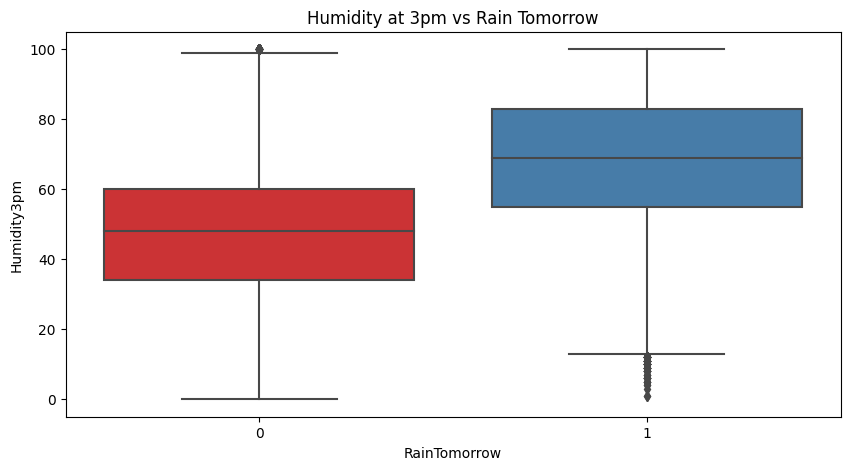

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(x="RainTomorrow", y="Humidity3pm", data=df, palette="Set1")
plt.title("Humidity at 3pm vs Rain Tomorrow")
plt.show()

**Average Rainfall by Location (top 15 cities)**

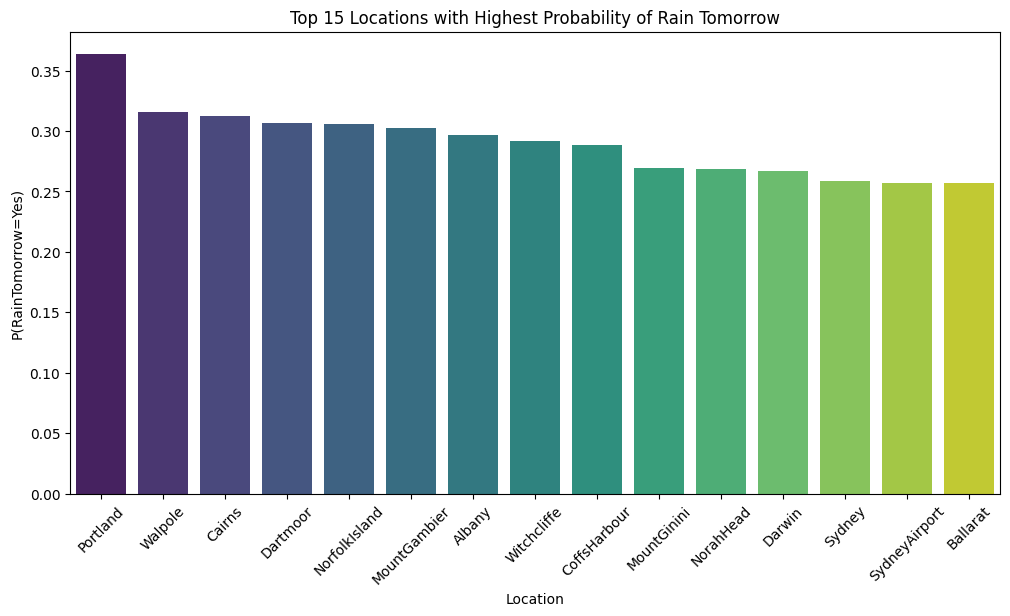

In [9]:
plt.figure(figsize=(12,6))
avg_rain = df.groupby("Location")["RainTomorrow"].mean().sort_values(ascending=False).head(15)
sns.barplot(x=avg_rain.index, y=avg_rain.values, palette="viridis")
plt.title("Top 15 Locations with Highest Probability of Rain Tomorrow")
plt.ylabel("P(RainTomorrow=Yes)")
plt.xticks(rotation=45)
plt.show()


**Wind Gust Direction vs RainTomorrow**

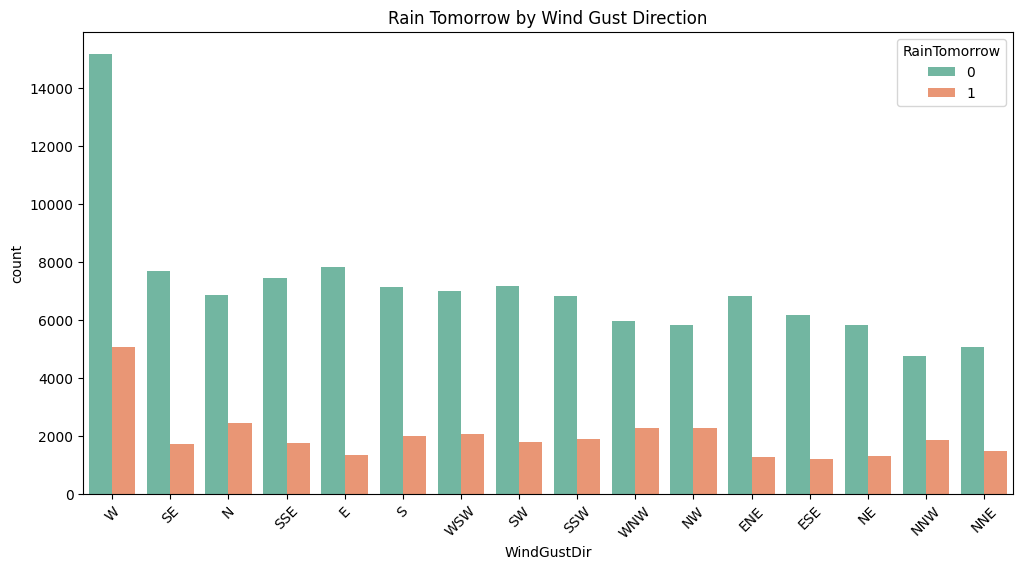

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(x="WindGustDir", hue="RainTomorrow", data=df, order=df["WindGustDir"].value_counts().index, palette="Set2")
plt.title("Rain Tomorrow by Wind Gust Direction")
plt.xticks(rotation=45)
plt.show()

In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)



Numeric columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow']
Categorical columns: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


**Histograms for key numeric columns**

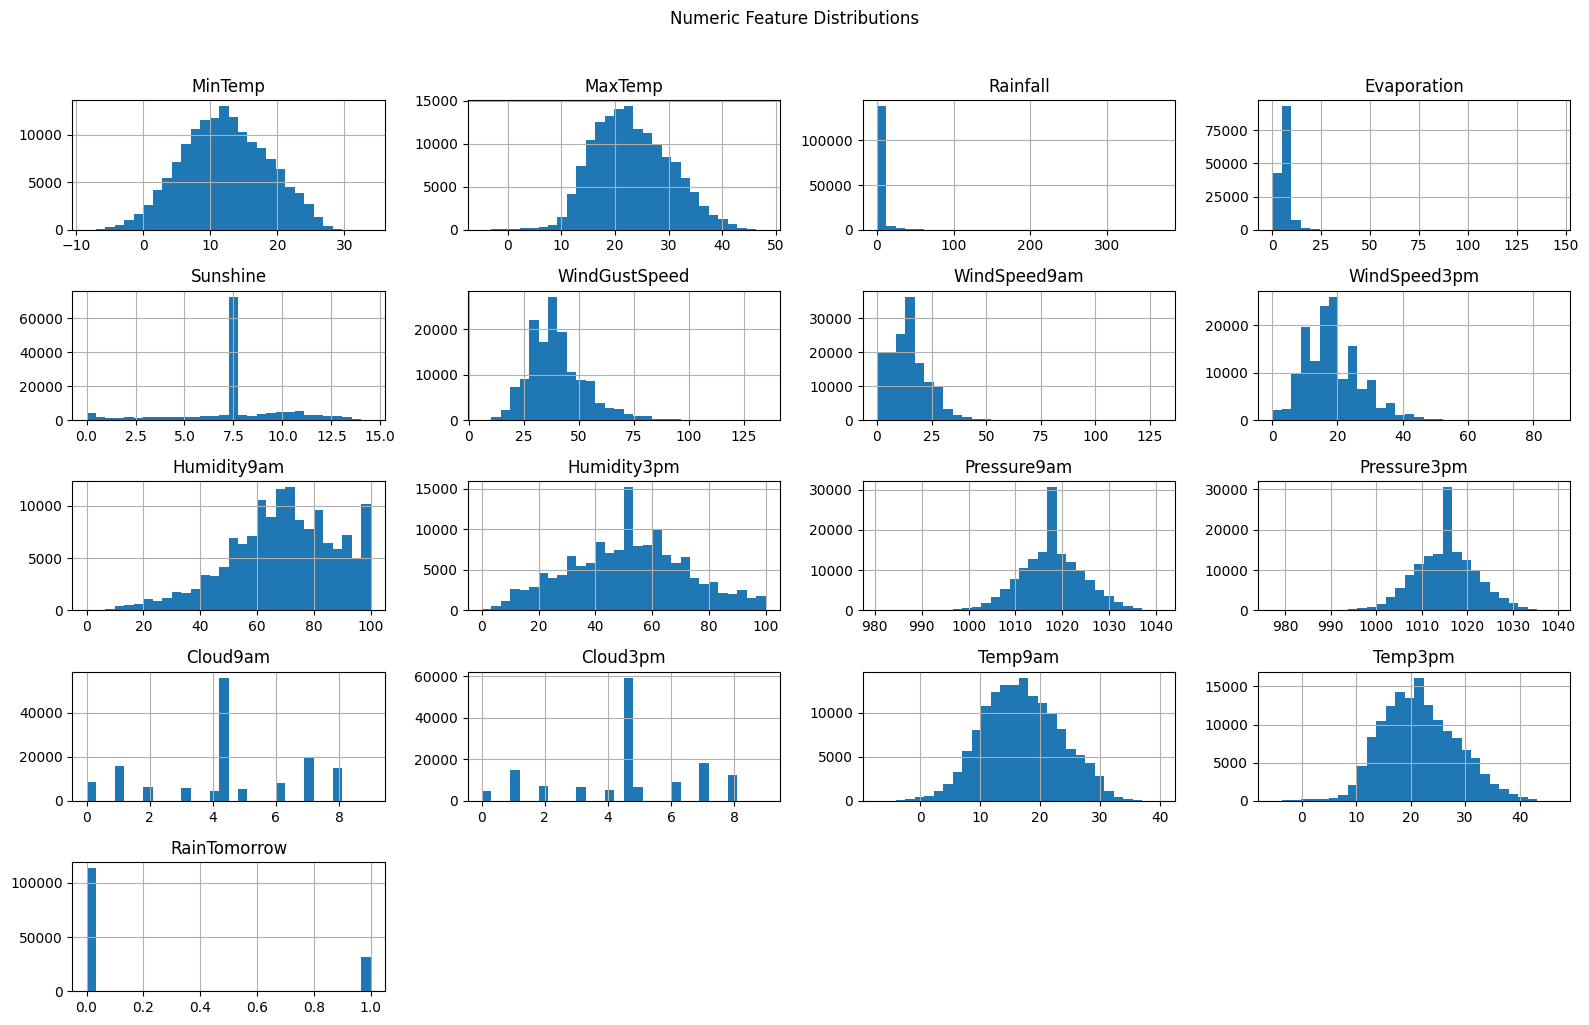

In [12]:
_ = df[num_cols].hist(bins=30, figsize=(16, 10))
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

**Correlation Heatmap (numeric only)**

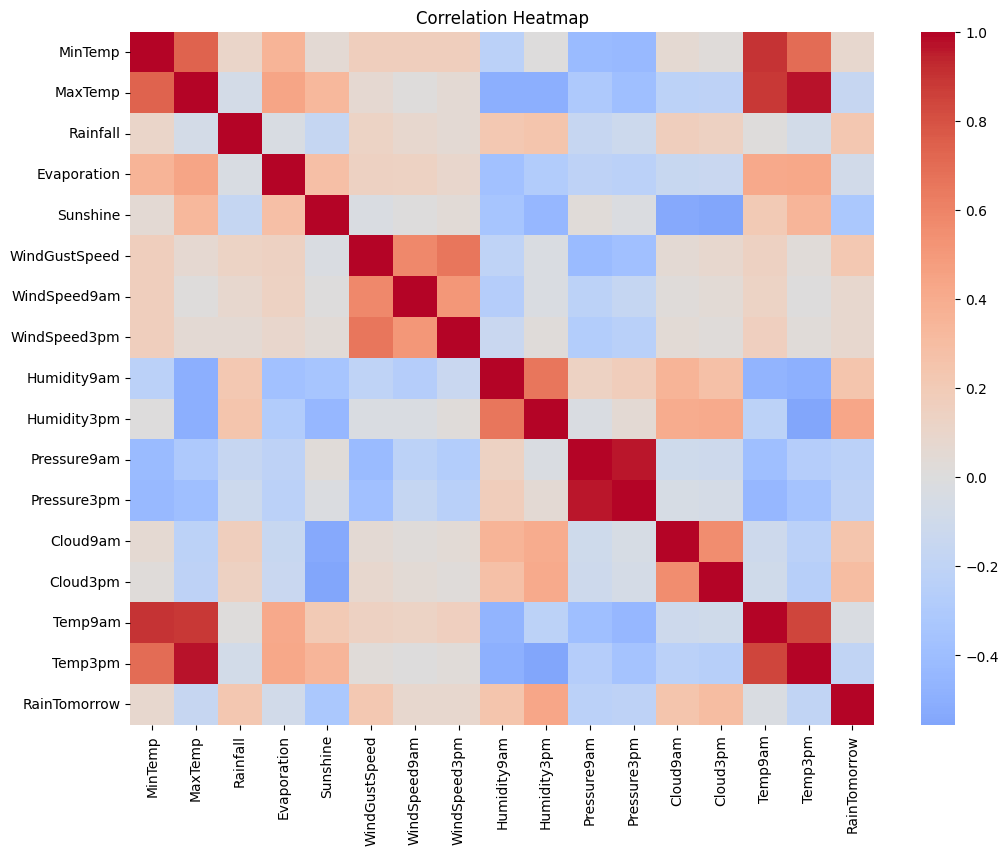

In [13]:
plt.figure(figsize=(12,9))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

**Parse date for EDA and features**

In [14]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
print("\nDate range:", df["Date"].min(), "to", df["Date"].max())


Date range: 2007-11-01 00:00:00 to 2017-06-25 00:00:00


**Step 4: Feature Engineering from Date**

In [15]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfYear"] = df["Date"].dt.dayofyear
df["IsWeekend"] = df["Date"].dt.weekday >= 5
df["IsWeekend"] = df["IsWeekend"].astype(int)

df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12.0)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12.0)
df["DoY_sin"]   = np.sin(2 * np.pi * df["DayOfYear"] / 366.0)
df["DoY_cos"]   = np.cos(2 * np.pi * df["DayOfYear"] / 366.0)

df = df.drop(columns=["Date"])

In [16]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainTomorrow,Year,Month,Day,DayOfYear,IsWeekend,Month_sin,Month_cos,DoY_sin,DoY_cos
0,Adelaide,10.8,21.2,0.0,1.8,6.60,ENE,22.0,ENE,NW,...,0,2010,4,30,120,0,0.866025,-0.500000,0.882679,-0.469977
1,Adelaide,3.7,19.0,0.0,1.4,7.61,N,24.0,N,NNE,...,0,2014,7,22,203,0,-0.500000,-0.866025,-0.336637,-0.941634
2,Adelaide,9.6,15.8,0.0,2.6,7.61,NE,52.0,NNE,NE,...,1,2014,7,23,204,0,-0.500000,-0.866025,-0.352752,-0.935717
3,Adelaide,10.1,15.5,16.6,0.8,7.61,NNE,50.0,NW,NW,...,1,2014,7,24,205,0,-0.500000,-0.866025,-0.368763,-0.929523
4,Adelaide,11.2,16.2,1.8,0.6,7.61,NW,30.0,WNW,WNW,...,1,2014,7,25,206,0,-0.500000,-0.866025,-0.384665,-0.923056


**Step 5: Train-Test Split**

In [17]:
TARGET = "RainTomorrow"
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nTrain/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (116368, 30) (29092, 30)


**Step 6: Preprocessing Pipelines**

In [19]:
numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_transformer_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, num_features),
        ("cat", categorical_transformer_ohe, cat_features),
    ]
)
numeric_transformer_linear = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_linear, num_features),
        ("cat", categorical_transformer_ohe, cat_features),
    ]
)

**Step 7: Utility to evaluate models**

In [20]:
def evaluate_model(name, model, X_test, y_test, proba_is_decision=False):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba") and not proba_is_decision:
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function") and proba_is_decision:
        y_scores = model.decision_function(X_test)
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)
    else:
        y_proba = y_pred.astype(float)

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba
    }
    return metrics

**Step 8: Define Models**

In [21]:
models = {}

models["LogisticRegression"] = Pipeline(steps=[
    ("preprocess", preprocess_linear),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None if hasattr(LogisticRegression(),'n_jobs') else None))
])
models["RandomForest"] = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=42, class_weight="balanced_subsample", n_jobs=-1
    ))
])
models["XGBoost"] = Pipeline(steps=[
        ("preprocess", preprocess_tree),
        ("clf", XGBClassifier(
            n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=42, n_jobs=-1, eval_metric="logloss", tree_method="hist"
        ))
    ])

models["LightGBM"] = Pipeline(steps=[
        ("preprocess", preprocess_tree),
        ("clf", LGBMClassifier(
            n_estimators=800, learning_rate=0.05, max_depth=-1, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        ))
    ])

**Step 9: Fit & Evaluate**

In [22]:
results = []
probas_for_roc = {}

for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    pipe.fit(X_train, y_train)
    r = evaluate_model(name, pipe, X_test, y_test)
    results.append({k: r[k] for k in ["model", "accuracy", "precision", "recall", "f1", "roc_auc"]})
    probas_for_roc[name] = r["y_proba"]


Training LogisticRegression ...

Training RandomForest ...

Training XGBoost ...

Training LightGBM ...
[LightGBM] [Info] Number of positive: 25502, number of negative: 90866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3578
[LightGBM] [Info] Number of data points in the train set: 116368, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219150 -> initscore=-1.270629
[LightGBM] [Info] Start training from score -1.270629


In [23]:
res_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False).reset_index(drop=True)
print("\nModel comparison:")
display(res_df)


Model comparison:


,model,accuracy,precision,recall,f1,roc_auc
0,XGBoost,0.860649,0.752228,0.542902,0.630649,0.896452
1,LightGBM,0.860649,0.750162,0.545882,0.631923,0.894530
2,RandomForest,0.855080,0.784154,0.467294,0.585610,0.891742
3,LogisticRegression,0.788842,0.512164,0.766118,0.613915,0.865687


**Step 10: CatBoost branch**

In [24]:
catboost_metrics = None
X_cb = X.copy()
cat_cols_cb = X_cb.select_dtypes(include=["object", "category"]).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=[X_train.columns.get_loc(c) for c in cat_cols_cb])
test_pool  = Pool(X_test,  y_test,  cat_features=[X_test.columns.get_loc(c) for c in cat_cols_cb])

cat_model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)
print("\nTraining CatBoost ...")
cat_model.fit(train_pool, eval_set=test_pool, verbose=False)
y_pred_cb = cat_model.predict(test_pool)
y_proba_cb = cat_model.predict_proba(test_pool)[:, 1]

catboost_metrics = {
    "model": "CatBoost",
    "accuracy": accuracy_score(y_test, y_pred_cb),
    "precision": precision_score(y_test, y_pred_cb, zero_division=0),
    "recall": recall_score(y_test, y_pred_cb, zero_division=0),
    "f1": f1_score(y_test, y_pred_cb, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba_cb),
    "y_pred": y_pred_cb,
    "y_proba": y_proba_cb,
    "estimator": cat_model
}
probas_for_roc["CatBoost"] = y_proba_cb
res_df = pd.concat([res_df, pd.DataFrame([{
    "model": "CatBoost",
    "accuracy": catboost_metrics["accuracy"],
    "precision": catboost_metrics["precision"],
    "recall": catboost_metrics["recall"],
    "f1": catboost_metrics["f1"],
    "roc_auc": catboost_metrics["roc_auc"],
}])], ignore_index=True).sort_values("roc_auc", ascending=False).reset_index(drop=True)

print("\nModel Comparison:")
display(res_df)


Training CatBoost ...

Model Comparison:


,model,accuracy,precision,recall,f1,roc_auc
0,CatBoost,0.862643,0.759320,0.546353,0.635468,0.899038
1,XGBoost,0.860649,0.752228,0.542902,0.630649,0.896452
2,LightGBM,0.860649,0.750162,0.545882,0.631923,0.894530
3,RandomForest,0.855080,0.784154,0.467294,0.585610,0.891742
4,LogisticRegression,0.788842,0.512164,0.766118,0.613915,0.865687


**Step 11: ROC Curves**

<Figure size 800x600 with 0 Axes>

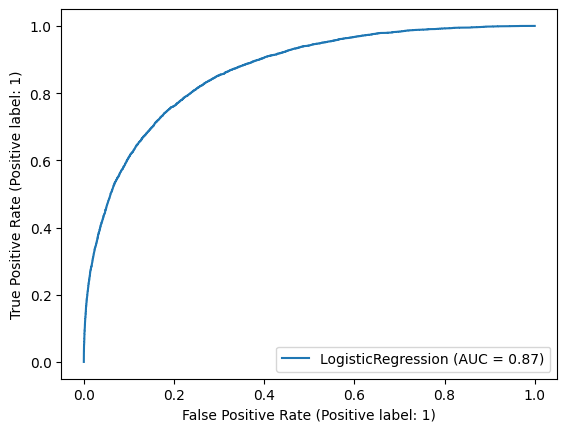

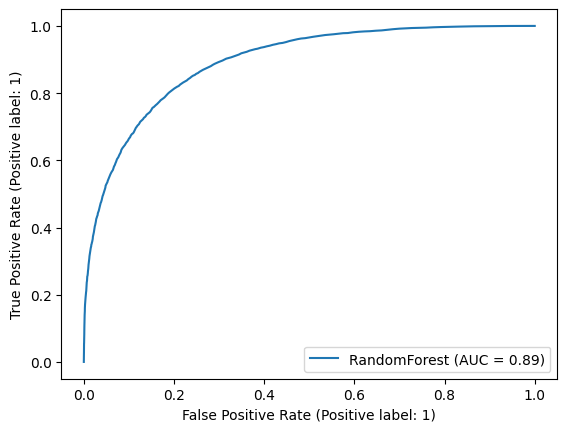

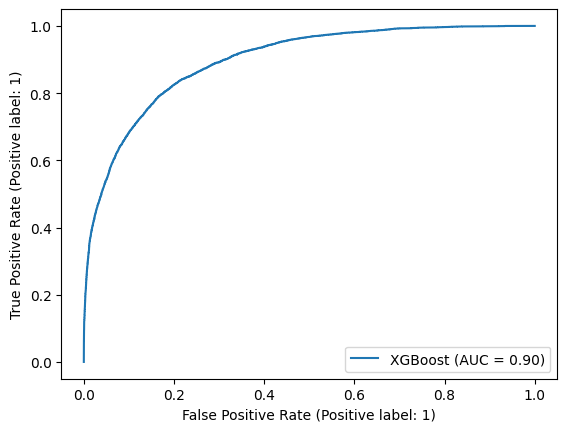

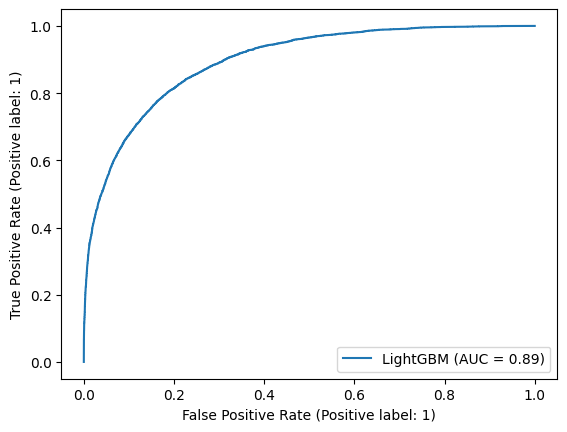

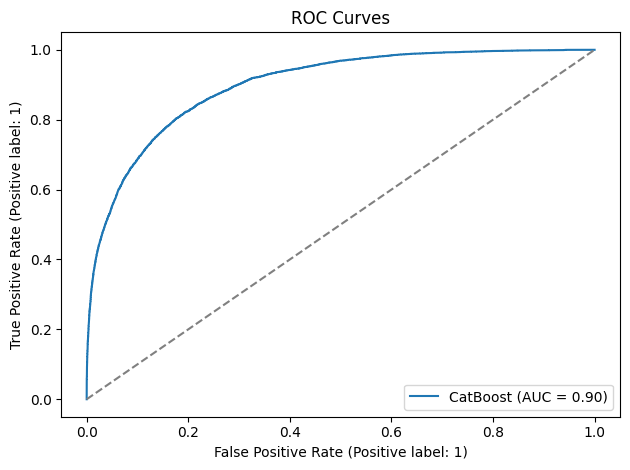


Best model: CatBoost (ROC AUC=0.8990)


In [25]:
plt.figure(figsize=(8, 6))
for name, y_proba in probas_for_roc.items():
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("ROC Curves")
plt.tight_layout()
plt.show()

best_row = res_df.iloc[0]
best_model_name = best_row["model"]
print(f"\nBest model: {best_model_name} (ROC AUC={best_row['roc_auc']:.4f})")

**Confusion Matrix**

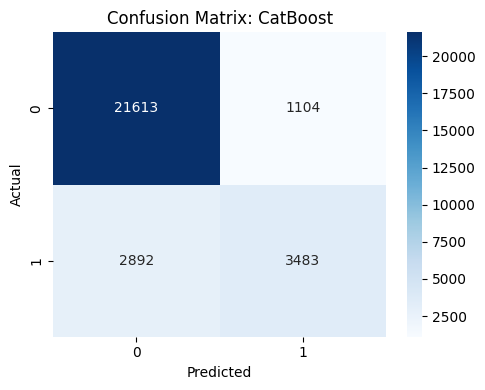

In [26]:
if best_model_name == "CatBoost" and catboost_metrics is not None:
    y_pred_best = catboost_metrics["y_pred"]
else:
    y_pred_best = models[best_model_name].predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

**Step 12: Feature Importances**

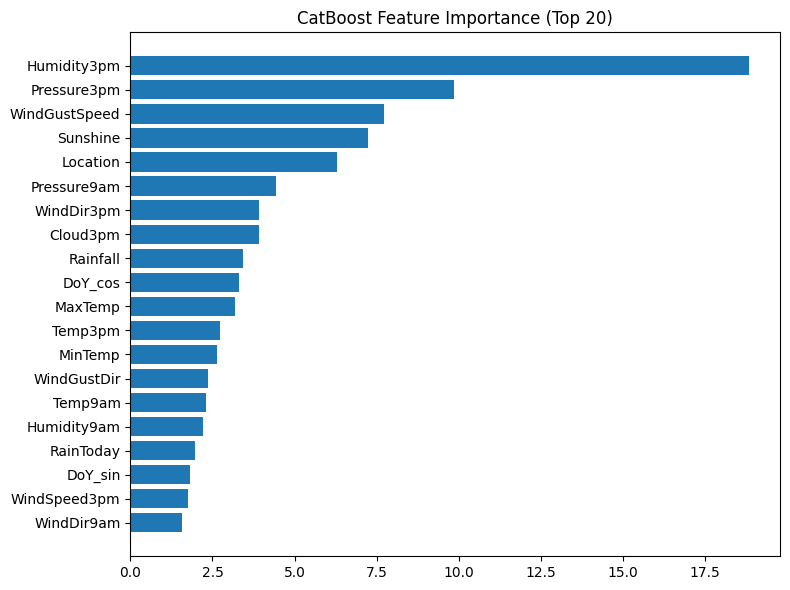

In [27]:
def plot_top_importances(model, feature_names, title):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[idx][::-1], importances[idx][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

if best_model_name == "CatBoost" and catboost_metrics is not None:
    cat_model = catboost_metrics["estimator"]
    cb_imps = cat_model.get_feature_importance(type="FeatureImportance")
    plt.figure(figsize=(8, 6))
    top_idx = np.argsort(cb_imps)[::-1][:20]
    plt.barh(X_train.columns[top_idx][::-1], np.array(cb_imps)[top_idx][::-1])
    plt.title("CatBoost Feature Importance (Top 20)")
    plt.tight_layout()
    plt.show()
else:
    pipe = models[best_model_name]
    pre = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["clf"]

    ohe = None
    for name, trans, cols in pre.transformers_:
        if name == "cat":
            ohe = trans.named_steps["onehot"]
            cat_cols_used = cols
        elif name == "num":
            num_cols_used = cols

    num_names = list(num_cols_used)
    cat_ohe_names = list(ohe.get_feature_names_out(cat_cols_used))
    all_feature_names = num_names + cat_ohe_names

    if hasattr(clf, "feature_importances_"):
        plot_top_importances(clf, all_feature_names, f"{best_model_name} Feature Importance (Top 20)")
    else:
        print(f"\n{best_model_name} does not expose feature_importances_.")
